In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from scipy.ndimage import gaussian_filter
import sys
from tqdm import tqdm
from functools import partial
import acd
from copy import deepcopy
sys.path.append('..')
sys.path.append('../..')
from transforms_torch import bandpass_filter
# plt.style.use('dark_background')
sys.path.append('../../dsets/mnist')
import dset
from model import Net, Net2c
from util import *
from numpy.fft import *
from torch import nn
from style import *
from captum.attr import (
    InputXGradient,
    Saliency,
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
)
import pickle as pkl
from torchvision import datasets, transforms
from sklearn.decomposition import NMF
import transform_wrappers
import visualize as viz
from model import Net, Net2c
torch.manual_seed(42)
np.random.seed(42)

In [2]:
from acd_wooseok.acd.scores import cd
from acd_wooseok.acd.util import tiling_2d
from acd_wooseok.acd.scores import score_funcs
from torchvision import datasets, transforms
# import modules
from funcs import *
from matfac import *
sys.path.append('../../..')
from hierarchical_dnn_interpretations.acd.scores import cd as acd

# Dataset

In [3]:
# load args
args = dset.get_args()
args.batch_size = int(args.batch_size/2) # half the batchsize
args.epochs = 50
args.cuda = not args.no_cuda and torch.cuda.is_available()

# load mnist dataloader
train_loader, test_loader = dset.load_data_with_indices(args.batch_size, args.test_batch_size, device)

# dataset
X = train_loader.dataset.data.numpy().astype(np.float32)
X = X.reshape(X.shape[0], -1)
X /= 255
Y = train_loader.dataset.targets.numpy()

X_test = test_loader.dataset.data.numpy().astype(np.float32)
X_test = X_test.reshape(X_test.shape[0], -1)
X_test /= 255
Y_test = test_loader.dataset.targets.numpy()

# load NMF object
# run NMF
# nmf = NMF(n_components=30, max_iter=1000)
# nmf.fit(X)
# pkl.dump(nmf, open('./results/nmf_30.pkl', 'wb'))
nmf = pkl.load(open('./results/nmf_30.pkl', 'rb'))
D = nmf.components_
# nmf transform
W = nmf.transform(X) 
W_test = nmf.transform(X_test) 

# Load model

In [4]:
dict_indx = 1
model = Net2c().to(device)
model.load_state_dict(torch.load('models/nmf/net2c_{}.pth'.format(dict_indx), map_location=device))
model = model.eval()

# knockout first dictionary and redefine train and test dataset
indx = np.argwhere(W[:,dict_indx] > 0).flatten()
indx_t = np.argwhere(W_test[:,dict_indx] > 0).flatten()

# subset dataloader
train_loader, test_loader = dset.load_data_with_indices(args.batch_size,
                                                        args.test_batch_size,
                                                        device,
                                                        subset_index=[indx, indx_t])

# CD score

In [5]:
# nmf transform layers
nmf_transformer = transform_wrappers.TransformLayers(D).to(device)

# convert nmf weight to tensor
W_test_t = torch.Tensor(W_test).to(device)
sweep_dim = 1
tiles = torch.Tensor(tiling_2d.gen_tiles(W_test[0:1], fill=0, method='cd', sweep_dim=sweep_dim)).to(device)

# store results
results = {
    'acd': [],
    'cd': []
}
for batch_indx, (data, target, data_indx) in enumerate(test_loader):
    # loop over nmf basis
    scores_acd = []
    scores_cd = []
    for basis_indx in range(nmf.n_components):
        im_parts = nmf_transformer(W_test_t[data_indx]*tiles[basis_indx]) 
        scores_acd.append(acd.cd(data, model, mask=None, model_type=None, device='cuda', transform=None,
                                 relevant=im_parts)[0].data.cpu().numpy()[:,0])        
        scores_cd.append(cd.cd(data, model, mask=None, model_type=None, device='cuda', transform=None,
                                 relevant=im_parts)[0].data.cpu().numpy()[:,0])
        
        print('\r batch index: {} [component index: {}]'.format(batch_indx, basis_indx), end='')  
    scores_acd = np.vstack(scores_acd).T
    scores_cd = np.vstack(scores_cd).T
    results['acd'].append(scores_acd)
    results['cd'].append(scores_cd)
results['acd'] = np.vstack(results['acd'])    
results['cd'] = np.vstack(results['cd'])    

 batch index: 3 [component index: 29]

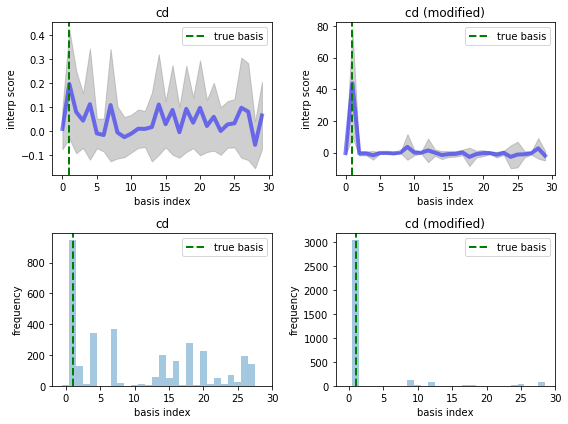

In [15]:
list_of_x = np.arange(nmf.n_components)
interp_modules = ['acd', 'cd']
titles = ['cd', 'cd (modified)']

i = 0
plt.figure(figsize=(8, 6))
for c in range(2):
    plt.subplot(2, 2, i + 1)
    plt.plot(list_of_x, results[interp_modules[i]].mean(axis=0), alpha=0.5, color='blue', linewidth=4.0)
    plt.fill_between(list_of_x, results[interp_modules[i]].mean(axis=0)-results[interp_modules[i]].std(axis=0), 
                results[interp_modules[i]].mean(axis=0)+results[interp_modules[i]].std(axis=0), color='#888888', alpha=0.4)
    plt.axvline(x=dict_indx, linestyle='--', color='green', label='true basis', linewidth=2.0)
    plt.legend()
    plt.xlabel('basis index')
    plt.ylabel('interp score')
    plt.title(titles[i])
    
    plt.subplot(2, 2, i + 3)
    plt.hist(np.argmax(results[interp_modules[i]],axis=1), bins=list_of_x-0.5, alpha=0.4)
    plt.axvline(x=dict_indx, linestyle='--', color='green', label='true basis', linewidth=2.0)
    plt.legend()
    plt.xlabel('basis index')
    plt.ylabel('frequency')
    plt.title(titles[i])    
    i += 1
plt.tight_layout()
plt.show()